# This notebook does a simultaneous 2-point, 3-point, and sum-subtracted fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
import pickle

In [4]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [6]:
data = {}
data['2pt'] = h5_dm.get_2pt("model_comparisons/a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3_unsymm'] = h5_dm.get_3pt("model_comparisons/a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4_unsymm'] = h5_dm.get_3pt("model_comparisons/a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("model_comparisons/a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("model_comparisons/a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("model_comparisons/a12m310_a_fh.h5", "all")


In [7]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Symmetrize the 3-point data
gv_avg_data['3pt_A3'] = np.array([ [ (gv_avg_data['3pt_A3_unsymm'][i][j] + gv_avg_data['3pt_A3_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_A3_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_A3_unsymm']))]) 
gv_avg_data['3pt_V4'] = np.array([ [ (gv_avg_data['3pt_V4_unsymm'][i][j] + gv_avg_data['3pt_V4_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_V4_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_V4_unsymm']))])

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']



<ipython-input-7-4e8eb793657b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-4e8eb793657b>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-4e8eb793657b>:21: RuntimeWarning: invalid value encoun

In [8]:
print(np.shape(gv_avg_data['2pt']))
print(np.shape(gv_avg_data['2pt_SS']))
print(np.shape(gv_avg_data['2pt_PS']))
print(np.shape(gv_avg_data['C^FH_combined']))
print(np.shape(gv_avg_data['FH_N']))

(64, 2)
(64,)
(64,)
(9, 2)
(64, 4)


## Prior d_N

In [9]:
#print(  gv_avg_data ['FH_N'][1])
tsep_1_d_N = gv_avg_data ['FH_N'][1]
e_E0 = np.array([gv_avg_data['2pt'][1][0]/gv_avg_data['2pt'][2][0], gv_avg_data['2pt'][1][1]/gv_avg_data['2pt'][2][1],\
                 gv_avg_data['2pt'][1][0]/gv_avg_data['2pt'][2][0], gv_avg_data['2pt'][1][1]/gv_avg_data['2pt'][2][1]])
print("d_0 values (A3_pp, A3_ps, V4_pp, V4_ps): ", e_E0*tsep_1_d_N)

d_0 values (A3_pp, A3_ps, V4_pp, V4_ps):  [-2.4718(86)e-06 -0.000017601(44) 2.2879(48)e-06 0.000014947(34)]


### Define functions

In [10]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
            if n >= m:
                sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
                sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
            if n >= m:    
                sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
                sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [11]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [12]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        if m > n:
            result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        else:
            result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        if m > n:
            result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        else:
            result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [13]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [14]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Ztilde{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Ztilde{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #,

In [15]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt' in t.keys():
        out['3pt_combined'] = C_3pt(t['3pt'], p)
    if 'sum_sub' in t.keys():
        out['C^FH_combined'] = C_FH(t['sum_sub'], p)
    if 'FH' in t.keys():
        out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [16]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d

<ipython-input-16-e0790b6350f7>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])


### Do the fit

In [17]:
num_zs = 7
num_states_FH = 2

prior = h5_dm.prior(num_zs, num_states_FH, 0.7, 0)
# prior the fits
#prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
#e_decay_exp = 0

#prior['E0'] = gv.gvar(0.67, 0.02)
#prior['Z0'] = gv.gvar(0.0008, 0.0003)
#prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
#dE0 = 2*mpi
#b = 1.3

# Use constant dE to prior the energies
#dE0 = 2*mpi
#energyvals = np.array([None]*num_zs)
#dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
#energyvals[0] = gv.gvar(0.67, 0.02)
#for k in range(1, num_zs):
    #dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    #energyvals[k] = energyvals[k-1] + dEvals[k-1]

#for n in range(1, num_zs):
    #prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    #prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0009)
    #prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)

#print(num_states_FH - 2)

#for n in range(num_zs):
    #for m in range(num_zs):
        
        #prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        #if n == m and n < num_zs-1:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        #else:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

#prior['gA3_00'] = gv.gvar(1.25, 0.15)
#prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#prior['Z_FHmax'] = gv.gvar(0.0012, 0.0009)
#prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
#prior['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

In [38]:
# Enumerate parameters
print("Number of params: ", len(prior.keys()), "\nparameter-list: ", [key for key in prior.keys()])

Number of params:  136 
parameter-list:  ['E0', 'Z0', 'Ztilde0', 'Z1', 'Ztilde1', 'Z2', 'Ztilde2', 'log(dE1)', 'log(dE2)', 'log(dE3)', 'Z3', 'Ztilde3', 'log(dE4)', 'Z4', 'Ztilde4', 'log(dE5)', 'Z5', 'Ztilde5', 'log(dE6)', 'Z6', 'Ztilde6', 'gA3_01', 'gV4_01', 'gA3_02', 'gV4_02', 'gA3_03', 'gV4_03', 'gA3_04', 'gV4_04', 'gA3_05', 'gV4_05', 'gA3_06', 'gV4_06', 'gA3_10', 'gV4_10', 'gA3_11', 'gV4_11', 'gA3_12', 'gV4_12', 'gA3_13', 'gV4_13', 'gA3_14', 'gV4_14', 'gA3_15', 'gV4_15', 'gA3_16', 'gV4_16', 'gA3_20', 'gV4_20', 'gA3_21', 'gV4_21', 'gA3_22', 'gV4_22', 'gA3_23', 'gV4_23', 'gA3_24', 'gV4_24', 'gA3_25', 'gV4_25', 'gA3_26', 'gV4_26', 'gA3_30', 'gV4_30', 'gA3_31', 'gV4_31', 'gA3_32', 'gV4_32', 'gA3_33', 'gV4_33', 'gA3_34', 'gV4_34', 'gA3_35', 'gV4_35', 'gA3_36', 'gV4_36', 'gA3_40', 'gV4_40', 'gA3_41', 'gV4_41', 'gA3_42', 'gV4_42', 'gA3_43', 'gV4_43', 'gA3_44', 'gV4_44', 'gA3_45', 'gV4_45', 'gA3_46', 'gV4_46', 'gA3_50', 'gV4_50', 'gA3_51', 'gV4_51', 'gA3_52', 'gV4_52', 'gA3_53', 'gV4_53', '

In [39]:
#prior['E0'] = gv.gvar(prior['E0'].mean, 0.02)
#prior['Z0'] = gv.gvar(prior['Z0'].mean, 0.0003)
#prior['Ztilde0'] = gv.gvar(prior['Ztilde0'].mean, 0.003)

#for n in range(1, num_zs):
    #prior['log(dE{})'.format(n)] = gv.gvar(prior['log(dE{})'.format(n)].mean, 0.7)
    #prior['Z{}'.format(n)] = gv.gvar(prior['Z{}'.format(n)].mean, 0.0009)
    #prior['Ztilde{}'.format(n)] = gv.gvar(prior['Ztilde{}'.format(n)].mean, 0.02)

#for n in range(num_zs):
    #for m in range(num_zs):
        
        #prior['gA3_{0}_{1}'.format(n, m)] = gv.gvar(prior['gA3_{0}{1}'.format(n, m)].mean, 2)
        #if n == m and n < num_zs-1:
            #prior['gV4_{0}_{1}'.format(n, m)] = gv.gvar(prior['gV4_{0}{1}'.format(n, m)].mean, 0.1)
        #else:
            #prior['gV4_{0}_{1}'.format(n, m)] = gv.gvar(prior['gV4_{0}{1}'.format(n, m)].mean, 3)



#prior['gA3_0_0'] = gv.gvar(prior['gA3_00'].mean, 0.15)
#prior['gV4_0_0'] = gv.gvar(prior['gV4_00'].mean, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#prior['Z_FHmax'] = gv.gvar(prior['Z_FHmax'].mean, 0.0009)
#prior['log(FH_dEmax)'] = gv.gvar(prior['log(FH_dEmax)'].mean, b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHmax_{}'.format(n)] = gv.gvar(prior['gA3_FHmax{}'.format(n)].mean, 2)
    #prior['gA3_{}_FHmax'.format(n)] = gv.gvar(prior['gA3_{}FHmax'.format(n)].mean, 2)
    #prior['gV4_FHmax_{}'.format(n)] = gv.gvar(prior['gV4_FHmax{}'.format(n)].mean, 3)
    #prior['gV4_{}_FHmax'.format(n)] = gv.gvar(prior['gV4_{}FHmax'.format(n)].mean, 3)
    
#prior['gA3_FHmax_FHmax'] = gv.gvar(prior['gA3_FHmaxFHmax'].mean, 2)
#prior['gV4_FHmax_FHmax'] = gv.gvar(prior['gV4_FHmaxFHmax'].mean, 3)

#prior

In [40]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt_uncut = t_1d_array
x_CFH = np.array([l for l in tsep_vals[:-1]])
x_CFH_mod = np.array([[x_CFH_el, None] for x_CFH_el in x_CFH])

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all_uncut = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_all = np.transpose(np.array([[y_CFH_A3], [y_CFH_V4]]), axes=[2,0,1])

# Now, cut the 3-point dataset in half to reflect the
x_3pt = []
y_3pt_all = []
for k in range(len(x_3pt_uncut)):
    if x_3pt_uncut[k][1] <= x_3pt_uncut[k][0]/2.:
        x_3pt.append(x_3pt_uncut[k].tolist())
        y_3pt_all.append(y_3pt_all_uncut[k].tolist())
        
x_3pt = np.array(x_3pt)
y_3pt_all = np.array(y_3pt_all)

    
x_all = np.append(x_2pt_mod, x_3pt_uncut, axis = 0)
x_all = np.append(x_all, x_CFH_mod, axis = 0)
y_all = np.append(y_2pt_all, y_3pt_all_uncut, axis = 0)
y_all = np.append(y_all, y_CFH_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt
x_all_dict['sum_sub'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all
y_all_dict['C^FH_combined'] = gv_avg_data['C^FH_combined']

#print(np.shape(x_2pt_mod))
#print(np.shape(x_3pt))
#print(np.shape(x_CFH_mod))
#print(np.shape(x_all))

#print(np.shape(y_2pt_all))
#print(np.shape(y_3pt_all))
#print(np.shape(y_CFH_all))
#print(np.shape(y_all))

fit_all = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)
print(fit_all.format(100))
post_all = fit_all.p

<ipython-input-40-2e296a4ee4a7>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-40-2e296a4ee4a7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 4.1 [108]    Q = 3.1e-41    logGBF = 2150

Parameters:
             E0     0.66616 (25)       [    0.665 (20) ]  
             Z0   0.0007850 (17)       [  0.00077 (78) ]  
        Ztilde0   0.0029856 (95)       [  0.00150 (50) ]  **
             Z1    0.000570 (64)       [  0.00050 (30) ]  
        Ztilde1     0.00435 (49)       [   0.0015 (10) ]  **
             Z2     0.00073 (12)       [  0.00050 (30) ]  
        Ztilde2     0.00729 (73)       [   0.0010 (10) ]  *****
       log(dE1)      -0.734 (64)       [    -0.98 (70) ]  
       log(dE2)       -0.88 (14)       [    -0.98 (70) ]  
       log(dE3)       -1.36 (43)       [    -0.98 (70) ]  
             Z3     0.00082 (13)       [  0.00030 (30) ]  *
        Ztilde3     0.00222 (48)       [  0.00050 (50) ]  ***
       log(dE4)       -0.37 (60)       [    -0.98 (70) ]  
             Z4     0.00045 (26)       [  0.00030 (30) ]  
        Ztilde4     0.00080 (50)       [  0.00050 (50) ]  
       log

In [41]:
current_posterior = open('all_postchained_out_symm.obj', 'wb')
pickle.dump(post_all, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [42]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-42-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-42-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-42-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [43]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtracted
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_all)
C2ptPS_model = C_2pt_PS(tsep_model, post_all)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_all)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_all)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
CFH_A3_model = C_FH_A3(t_FH_model, post_all)
CFH_V4_model = C_FH_V4(t_FH_model, post_all)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_all)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-43-0a7369a64480>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-43-0a7369a64480>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-43-0a7369a64480>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

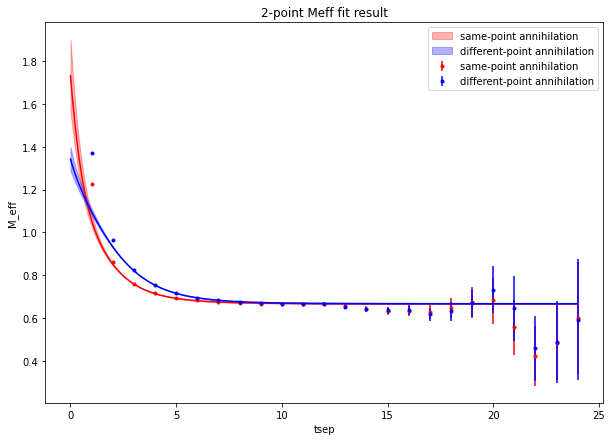

<Figure size 432x288 with 0 Axes>

In [44]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

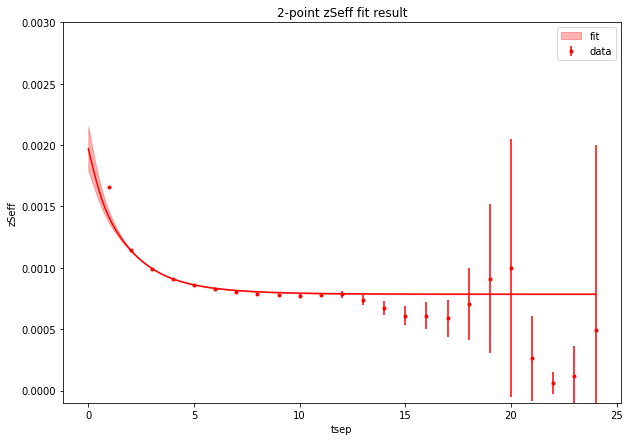

<Figure size 432x288 with 0 Axes>

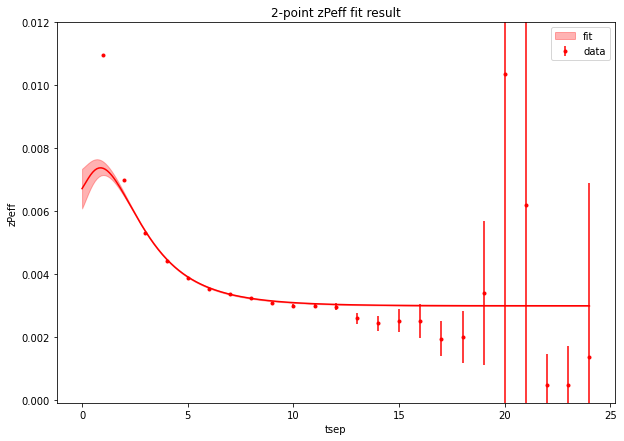

<Figure size 432x288 with 0 Axes>

In [45]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

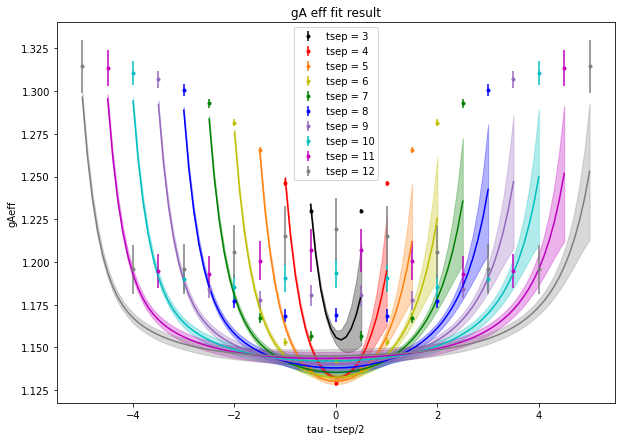

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

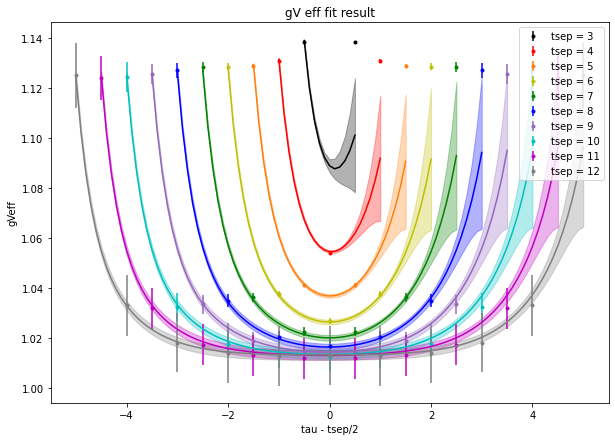

<Figure size 432x288 with 0 Axes>

In [46]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


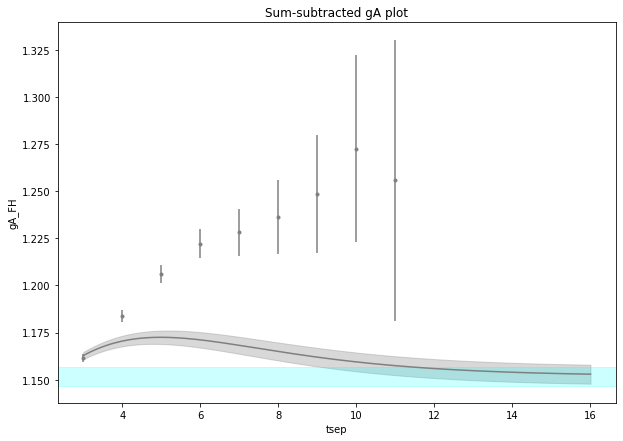

<Figure size 432x288 with 0 Axes>

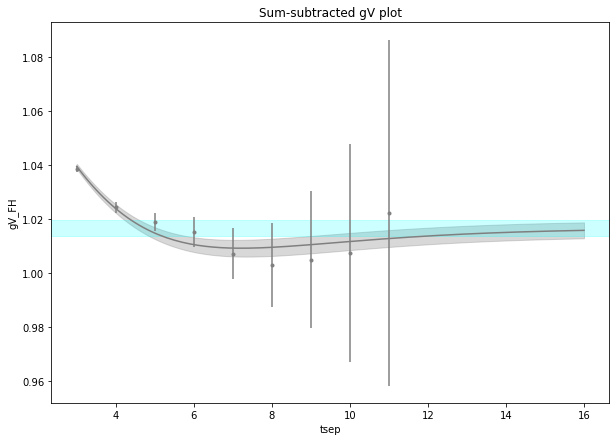

<Figure size 432x288 with 0 Axes>

In [47]:
h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_all['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_all['gV4_00'], ydat_error=y_CFH_V4_err)


### Now, make an attempt with the FH data

In [17]:
num_zs = 7
num_states_FH = 4

prior = h5_dm.prior(num_zs, num_states_FH, 0.7, 0)
# prior the fits
#prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
#e_decay_exp = 0

#prior['E0'] = gv.gvar(0.67, 0.02)
#prior['Z0'] = gv.gvar(0.0008, 0.0003)
#prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
#dE0 = 2*mpi
#b = 1.3

# Use constant dE to prior the energies
#dE0 = 2*mpi
#energyvals = np.array([None]*num_zs)
#dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
#energyvals[0] = gv.gvar(0.67, 0.02)
#for k in range(1, num_zs):
    #dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    #energyvals[k] = energyvals[k-1] + dEvals[k-1]

#for n in range(1, num_zs):
    #prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    #prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0009)
    #prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)

#print(num_states_FH - 2)

#for n in range(num_zs):
    #for m in range(num_zs):
        
        #prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        #if n == m and n < num_zs-1:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        #else:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

#prior['gA3_00'] = gv.gvar(1.25, 0.15)
#prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#prior['Z_FHmax'] = gv.gvar(0.0012, 0.0009)
#prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
#prior['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

In [17]:
# Import a set of initial values for the parameters from the chained fit
chainedfit_res = open("Final(3pt)_withFH_out.obj", 'rb')
p0_fromchained = pickle.load(chainedfit_res)
chainedfit_res.close()

p0_fromchained_means = gv.BufferDict()
for key in p0_fromchained.keys():
    p0_fromchained_means[key] = p0_fromchained[key].mean

In [18]:
print("Number of params: ", len(prior.keys()), "\nparams: ", [key for key in prior.keys()])

#p0_fromchained
print(type(p0_fromchained))
print(type(prior))

NameError: name 'prior' is not defined

In [19]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt_uncut = t_1d_array
x_CFH = np.array([l for l in tsep_vals[:-1]])
x_CFH_mod = np.array([[x_CFH_el, None] for x_CFH_el in x_CFH])

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all_uncut = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_all = np.transpose(np.array([[y_CFH_A3], [y_CFH_V4]]), axes=[2,0,1])

# Now, cut the 3-point dataset in half to reflect the
x_3pt = []
y_3pt_all = []
for k in range(len(x_3pt_uncut)):
    if x_3pt_uncut[k][1] <= x_3pt_uncut[k][0]/2.:
        x_3pt.append(x_3pt_uncut[k].tolist())
        y_3pt_all.append(y_3pt_all_uncut[k].tolist())
        
x_3pt = np.array(x_3pt)
y_3pt_all = np.array(y_3pt_all)

    
x_all = np.append(x_2pt_mod, x_3pt_uncut, axis = 0)
x_all = np.append(x_all, x_CFH_mod, axis = 0)
y_all = np.append(y_2pt_all, y_3pt_all_uncut, axis = 0)
y_all = np.append(y_all, y_CFH_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

#x_all_dict['2pt'] = x_2pt
#x_all_dict['3pt'] = x_3pt
#x_all_dict['sum_sub'] = tsep_vals[:-1]
#x_all_dict['FH'] = tsep_vals[:-1]

#y_all_dict['2pt'] = y_2pt_all
#y_all_dict['3pt_combined'] = y_3pt_all
#y_all_dict['C^FH_combined'] = gv_avg_data['C^FH_combined']
#y_all_dict['FH'] =  gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

x_all_dict['2pt'] = x_2pt[1:-2]
x_all_dict['3pt'] = x_3pt[1:-11]
x_all_dict['sum_sub'] = tsep_vals[1:-2]
x_all_dict['FH'] = tsep_vals[1:-2]

y_all_dict['2pt'] = y_2pt_all[1:-2]
y_all_dict['3pt_combined'] = y_3pt_all[1:-11]
y_all_dict['C^FH_combined'] = gv_avg_data['C^FH_combined'][1:-1]
y_all_dict['FH'] =  gv_avg_data['FH'][4:11]

#print(np.shape(x_2pt_mod))
#print(np.shape(x_3pt))
#print(np.shape(x_CFH_mod))
#print(np.shape(x_all))

#print(np.shape(y_2pt_all))
#print(np.shape(y_3pt_all))
#print(np.shape(y_CFH_all))
#print(np.shape(y_all))

#print("x dictionary fitted to: ", x_all_dict)
#print("y dictionary fitted to: ", y_all_dict)

fit_all = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000, p0 = p0_fromchained_means)
print(fit_all.format(100))
post_all = fit_all.p

x dictionary fitted to:  {'2pt': array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),'3pt': array([[ 4.,  1.],
       [ 4.,  2.],
       [ 5.,  1.],
       [ 5.,  2.],
       [ 6.,  1.],
       [ 6.,  2.],
       [ 6.,  3.],
       [ 7.,  1.],
       [ 7.,  2.],
       [ 7.,  3.],
       [ 8.,  1.],
       [ 8.,  2.],
       [ 8.,  3.],
       [ 8.,  4.],
       [ 9.,  1.],
       [ 9.,  2.],
       [ 9.,  3.],
       [ 9.,  4.],
       [10.,  1.],
       [10.,  2.],
       [10.,  3.],
       [10.,  4.],
       [10.,  5.]]),'sum_sub': array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),'FH': array([ 4.,  5.,  6.,  7.,  8.,  9., 10.])}
y dictionary fitted to:  {'2pt': array([[[4.687(16)e-08],
        [1.9605(77)e-07]],

       [[2.2927(79)e-08],
        [9.236(36)e-08]],

       [[1.1461(43)e-08],
        [4.515(18)e-08]],

       [[5.798(25)e-09],
        [2.2535(98)e-08]],

       [[2.958(15)e-09],
        [1.1378(56)e-08]],

       [[1.5177(91)e-09],
        [5.791(34)e-09]],

       [[7.803(58)e-10],

<ipython-input-19-f447f377d01a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-19-f447f377d01a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


NameError: name 'prior' is not defined

In [37]:
current_posterior = open('all_postchained_withFH_out_symm_7_4_shortened_symmg.obj', 'wb')
pickle.dump(post_all, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [38]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-38-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-38-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-38-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [39]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman 
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_all)
C2ptPS_model = C_2pt_PS(tsep_model, post_all)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_all)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_all)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
CFH_A3_model = C_FH_A3(t_FH_model, post_all)
CFH_V4_model = C_FH_V4(t_FH_model, post_all)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_all)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-39-61a8a42a49f5>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-39-61a8a42a49f5>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-39-61a8a42a49f5>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

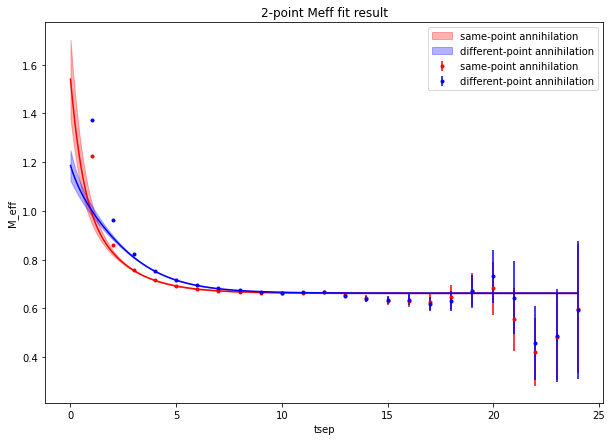

<Figure size 432x288 with 0 Axes>

In [40]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

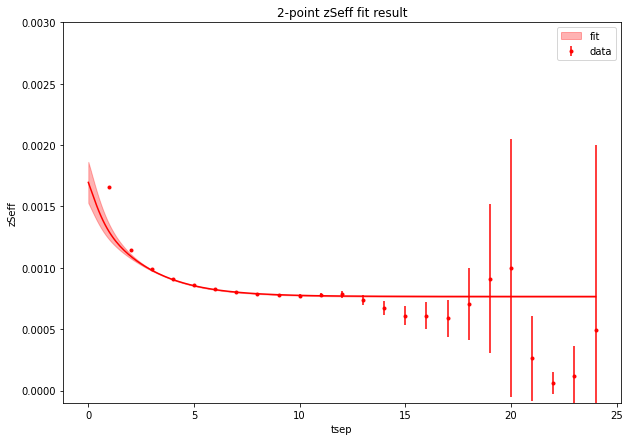

<Figure size 432x288 with 0 Axes>

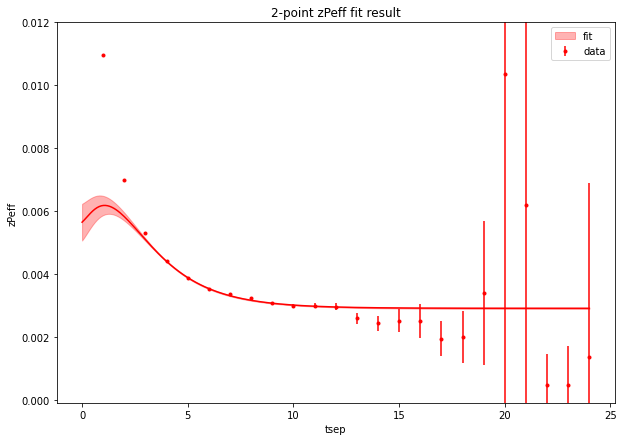

<Figure size 432x288 with 0 Axes>

In [41]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

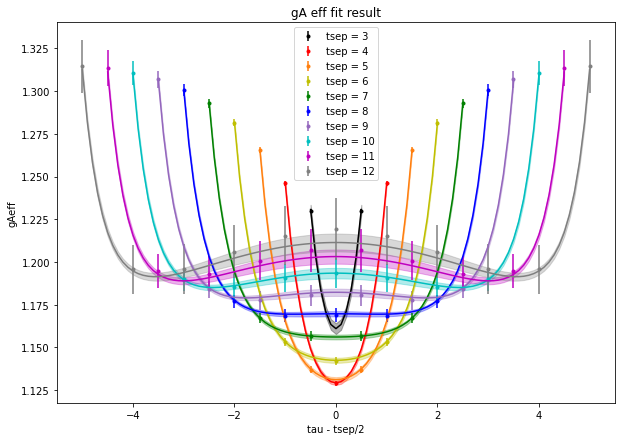

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

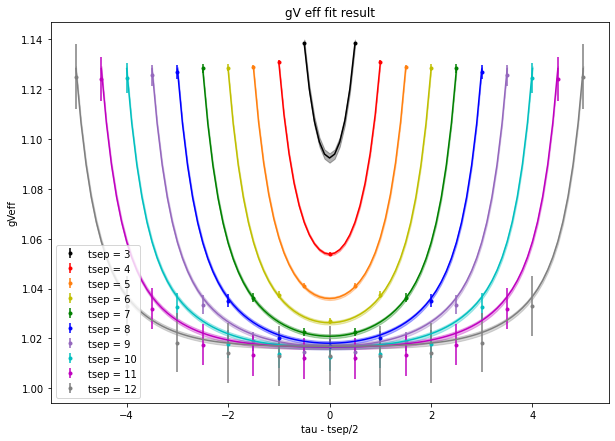

<Figure size 432x288 with 0 Axes>

In [42]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


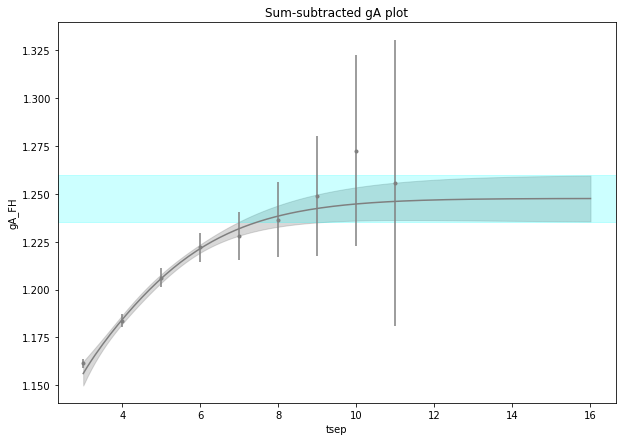

<Figure size 432x288 with 0 Axes>

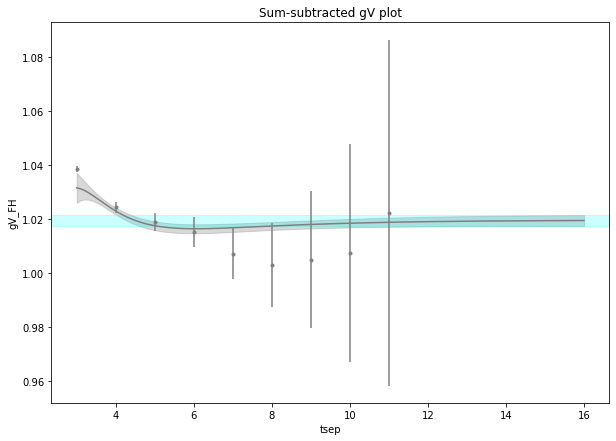

<Figure size 432x288 with 0 Axes>

In [43]:
h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_all['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_all['gV4_00'], ydat_error=y_CFH_V4_err)


## Now, sample for tau 2

In [57]:
num_zs = 4
num_states_FH = 3

prior = h5_dm.prior(num_zs, num_states_FH, 0.7, 0)
# prior the fits
#prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
#e_decay_exp = 0

#prior['E0'] = gv.gvar(0.67, 0.02)
#prior['Z0'] = gv.gvar(0.0008, 0.0003)
#prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
#dE0 = 2*mpi
#b = 1.3

# Use constant dE to prior the energies
#dE0 = 2*mpi
#energyvals = np.array([None]*num_zs)
#dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
#energyvals[0] = gv.gvar(0.67, 0.02)
#for k in range(1, num_zs):
    #dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    #energyvals[k] = energyvals[k-1] + dEvals[k-1]

#for n in range(1, num_zs):
    #prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    #prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0009)
    #prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)

#print(num_states_FH - 2)

#for n in range(num_zs):
    #for m in range(num_zs):
        
        #prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        #if n == m and n < num_zs-1:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        #else:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

#prior['gA3_00'] = gv.gvar(1.25, 0.15)
#prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#prior['Z_FHmax'] = gv.gvar(0.0012, 0.0009)
#prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
#prior['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

In [58]:
#read_chainz = open("Final(3pt)_out.obj", 'rb')
#prior = pickle.load(read_chainz)
#read_chainz.close()
#prior

In [59]:
#prior['E0'] = gv.gvar(prior['E0'].mean, 0.02)
#prior['Z0'] = gv.gvar(prior['Z0'].mean, 0.0003)
#prior['Ztilde0'] = gv.gvar(prior['Ztilde0'].mean, 0.003)

#for n in range(1, num_zs):
    #prior['log(dE{})'.format(n)] = gv.gvar(prior['log(dE{})'.format(n)].mean, 0.7)
    #prior['Z{}'.format(n)] = gv.gvar(prior['Z{}'.format(n)].mean, 0.0009)
    #prior['Ztilde{}'.format(n)] = gv.gvar(prior['Ztilde{}'.format(n)].mean, 0.02)

#for n in range(num_zs):
    #for m in range(num_zs):
        
        #prior['gA3_{0}_{1}'.format(n, m)] = gv.gvar(prior['gA3_{0}{1}'.format(n, m)].mean, 2)
        #if n == m and n < num_zs-1:
            #prior['gV4_{0}_{1}'.format(n, m)] = gv.gvar(prior['gV4_{0}{1}'.format(n, m)].mean, 0.1)
        #else:
            #prior['gV4_{0}_{1}'.format(n, m)] = gv.gvar(prior['gV4_{0}{1}'.format(n, m)].mean, 3)



#prior['gA3_0_0'] = gv.gvar(prior['gA3_00'].mean, 0.15)
#prior['gV4_0_0'] = gv.gvar(prior['gV4_00'].mean, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#prior['Z_FHmax'] = gv.gvar(prior['Z_FHmax'].mean, 0.0009)
#prior['log(FH_dEmax)'] = gv.gvar(prior['log(FH_dEmax)'].mean, b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHmax_{}'.format(n)] = gv.gvar(prior['gA3_FHmax{}'.format(n)].mean, 2)
    #prior['gA3_{}_FHmax'.format(n)] = gv.gvar(prior['gA3_{}FHmax'.format(n)].mean, 2)
    #prior['gV4_FHmax_{}'.format(n)] = gv.gvar(prior['gV4_FHmax{}'.format(n)].mean, 3)
    #prior['gV4_{}_FHmax'.format(n)] = gv.gvar(prior['gV4_{}FHmax'.format(n)].mean, 3)
    
#prior['gA3_FHmax_FHmax'] = gv.gvar(prior['gA3_FHmaxFHmax'].mean, 2)
#prior['gV4_FHmax_FHmax'] = gv.gvar(prior['gV4_FHmaxFHmax'].mean, 3)

#prior

In [62]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt_uncut = t_1d_array
x_CFH = np.array([l for l in tsep_vals[:-1]])
x_CFH_mod = np.array([[x_CFH_el, None] for x_CFH_el in x_CFH])

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all_uncut = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_all = np.transpose(np.array([[y_CFH_A3], [y_CFH_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_3pt_tau2_uncut = []
y_3pt_tau2_uncut = []

tau_cut_val = 2    
for k in range(len(x_3pt_uncut)):
    if(x_3pt_uncut[k][0] >= 4):
        if(x_3pt_uncut[k][1] >= tau_cut_val):
            if(x_3pt_uncut[k][1] <= x_3pt_uncut[k][0] - tau_cut_val):
                x_3pt_tau2_uncut.append(x_3pt_uncut[k].tolist())
                y_3pt_tau2_uncut.append(y_3pt_all_uncut[k].tolist())
                            
x_3pt_tau2_uncut = np.array(x_3pt_tau2_uncut)
y_3pt_tau2_uncut = np.array(y_3pt_tau2_uncut)


# Now, cut the 3-point dataset in half to reflect the
x_3pt_tau2 = []
y_3pt_all_tau2 = []
for k in range(len(x_3pt_tau2_uncut)):
    if x_3pt_tau2_uncut[k][1] <= x_3pt_tau2_uncut[k][0]/2.:
        x_3pt_tau2.append(x_3pt_tau2_uncut[k].tolist())
        y_3pt_all_tau2.append(y_3pt_tau2_uncut[k].tolist())
        
x_3pt_tau2 = np.array(x_3pt_tau2)
y_3pt_all_tau2 = np.array(y_3pt_all_tau2)



# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt_tau2
x_all_dict['sum_sub'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all_tau2
y_all_dict['C^FH_combined'] = gv_avg_data['C^FH_combined']

#print(np.shape(x_2pt_mod))
#print(np.shape(x_3pt))
#print(np.shape(x_CFH_mod))
#print(np.shape(x_all))

#print(np.shape(y_2pt_all))
#print(np.shape(y_3pt_all))
#print(np.shape(y_CFH_all))
#print(np.shape(y_all))

fit_all = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)
print(fit_all.format(100))
post_all = fit_all.p

<ipython-input-62-ee8280858c58>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-62-ee8280858c58>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 1.2 [88]    Q = 0.078    logGBF = 1796.1

Parameters:
             E0      0.6632 (26)       [    0.665 (20) ]  
             Z0    0.000764 (10)       [  0.00077 (78) ]  
        Ztilde0    0.002885 (44)       [  0.00150 (50) ]  **
             Z1    0.000455 (87)       [  0.00050 (30) ]  
        Ztilde1     0.00329 (56)       [   0.0015 (10) ]  *
             Z2    0.001047 (49)       [  0.00050 (30) ]  *
        Ztilde2     0.00759 (35)       [   0.0010 (10) ]  *****
       log(dE1)       -1.00 (14)       [    -0.98 (70) ]  
       log(dE2)      -0.636 (99)       [    -0.98 (70) ]  
       log(dE3)       -0.69 (54)       [    -0.98 (70) ]  
             Z3     0.00041 (20)       [  0.00030 (30) ]  
        Ztilde3     0.00081 (50)       [  0.00050 (50) ]  
         gA3_01       -0.34 (11)       [     0.0 (1.0) ]  
         gV4_01      -0.029 (21)       [     0.0 (1.0) ]  
         gA3_02        0.07 (15)       [     0.0 (1.0) ]  
         gV4_02

In [63]:
current_posterior = open('all_postchained_out_tau2_symm.obj', 'wb')
pickle.dump(post_all, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [64]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-64-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-64-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-64-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [65]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman 
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_all)
C2ptPS_model = C_2pt_PS(tsep_model, post_all)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_all)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_all)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
CFH_A3_model = C_FH_A3(t_FH_model, post_all)
CFH_V4_model = C_FH_V4(t_FH_model, post_all)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_all)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-65-61a8a42a49f5>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-65-61a8a42a49f5>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-65-61a8a42a49f5>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

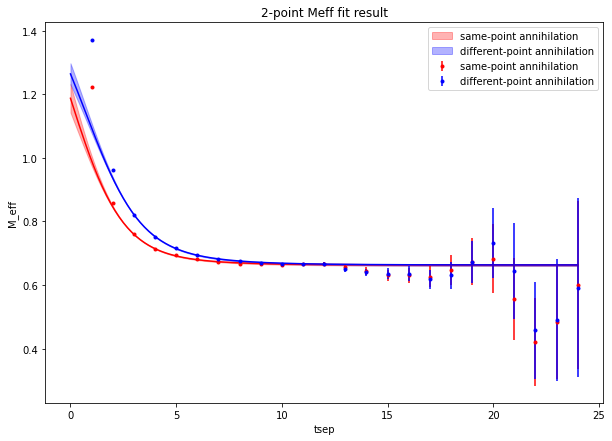

<Figure size 432x288 with 0 Axes>

In [66]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

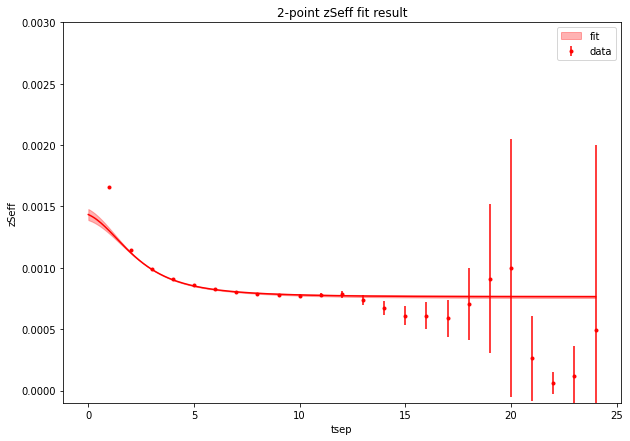

<Figure size 432x288 with 0 Axes>

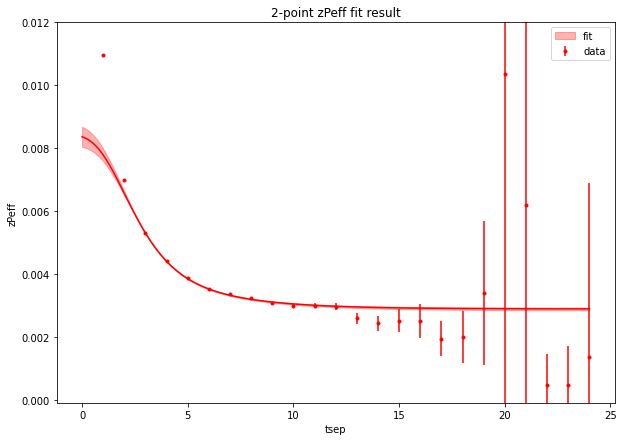

<Figure size 432x288 with 0 Axes>

In [67]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

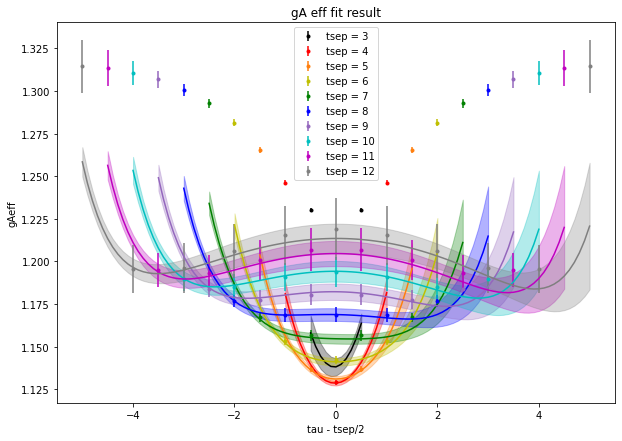

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

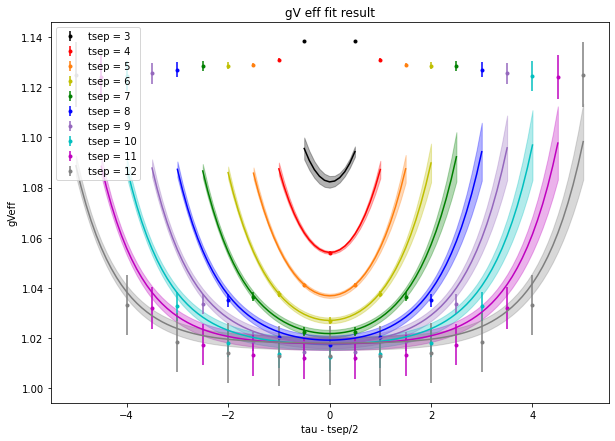

<Figure size 432x288 with 0 Axes>

In [68]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


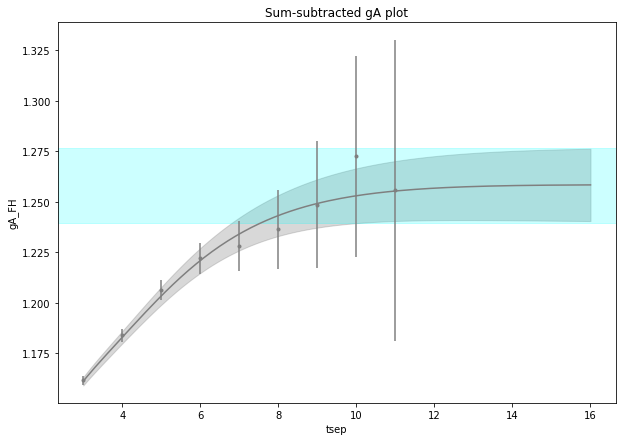

<Figure size 432x288 with 0 Axes>

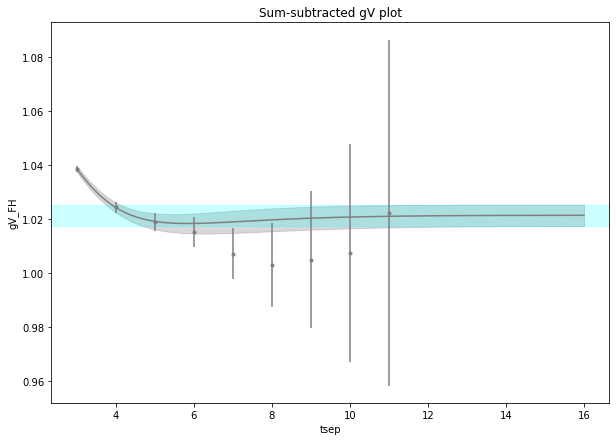

<Figure size 432x288 with 0 Axes>

In [69]:
h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_all['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_all['gV4_00'], ydat_error=y_CFH_V4_err)


### Now, make an attempt with the FH data

In [70]:
num_zs = 4
num_states_FH = 3

prior = h5_dm.prior(num_zs, num_states_FH, 0.7, 0)
# prior the fits
#prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
#e_decay_exp = 0

#prior['E0'] = gv.gvar(0.67, 0.02)
#prior['Z0'] = gv.gvar(0.0008, 0.0003)
#prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
#dE0 = 2*mpi
#b = 1.3

# Use constant dE to prior the energies
#dE0 = 2*mpi
#energyvals = np.array([None]*num_zs)
#dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
#energyvals[0] = gv.gvar(0.67, 0.02)
#for k in range(1, num_zs):
    #dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    #energyvals[k] = energyvals[k-1] + dEvals[k-1]

#for n in range(1, num_zs):
    #prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    #prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0009)
    #prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)

#print(num_states_FH - 2)

#for n in range(num_zs):
    #for m in range(num_zs):
        
        #prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        #if n == m and n < num_zs-1:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        #else:
            #prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

#prior['gA3_00'] = gv.gvar(1.25, 0.15)
#prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#prior['Z_FHmax'] = gv.gvar(0.0012, 0.0009)
#prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
#prior['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

In [72]:

# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt_uncut = t_1d_array
x_CFH = np.array([l for l in tsep_vals[:-1]])
x_CFH_mod = np.array([[x_CFH_el, None] for x_CFH_el in x_CFH])

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all_uncut = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][l] for l in range(len(tsep_vals[:-1]))])
y_CFH_all = np.transpose(np.array([[y_CFH_A3], [y_CFH_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_3pt_tau2_uncut = []
y_3pt_tau2_uncut = []

tau_cut_val = 2    
for k in range(len(x_3pt_uncut)):
    if(x_3pt_uncut[k][0] >= 4):
        if(x_3pt_uncut[k][1] >= tau_cut_val):
            if(x_3pt_uncut[k][1] <= x_3pt_uncut[k][0] - tau_cut_val):
                x_3pt_tau2_uncut.append(x_3pt_uncut[k].tolist())
                y_3pt_tau2_uncut.append(y_3pt_all_uncut[k].tolist())
                            
x_3pt_tau2_uncut = np.array(x_3pt_tau2_uncut)
y_3pt_tau2_uncut = np.array(y_3pt_tau2_uncut)


# Now, cut the 3-point dataset in half to reflect the
x_3pt_tau2 = []
y_3pt_all_tau2 = []
for k in range(len(x_3pt_tau2_uncut)):
    if x_3pt_tau2_uncut[k][1] <= x_3pt_tau2_uncut[k][0]/2.:
        x_3pt_tau2.append(x_3pt_tau2_uncut[k].tolist())
        y_3pt_all_tau2.append(y_3pt_tau2_uncut[k].tolist())
        
x_3pt_tau2 = np.array(x_3pt_tau2)
y_3pt_all_tau2 = np.array(y_3pt_all_tau2)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()


x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt_tau2
x_all_dict['sum_sub'] = tsep_vals[:-1]
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all_tau2
y_all_dict['C^FH_combined'] = gv_avg_data['C^FH_combined']
y_all_dict['FH'] =  gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

#print(np.shape(x_2pt_mod))
#print(np.shape(x_3pt))
#print(np.shape(x_CFH_mod))
#print(np.shape(x_all))

#print(np.shape(y_2pt_all))
#print(np.shape(y_3pt_all))
#print(np.shape(y_CFH_all))
#print(np.shape(y_all))

fit_all = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True, maxit=1000)
print(fit_all.format(100))
post_all = fit_all.p

<ipython-input-72-9ca8184780f4>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-72-9ca8184780f4>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 1.1 [124]    Q = 0.14    logGBF = 1938

Parameters:
             E0       0.6638 (22)       [    0.665 (20) ]  
             Z0    0.0007671 (81)       [  0.00077 (78) ]  
        Ztilde0     0.002899 (35)       [  0.00150 (50) ]  **
             Z1     0.000471 (78)       [  0.00050 (30) ]  
        Ztilde1      0.00354 (44)       [   0.0015 (10) ]  **
             Z2     0.001046 (52)       [  0.00050 (30) ]  *
        Ztilde2      0.00746 (34)       [   0.0010 (10) ]  *****
       log(dE1)       -0.937 (92)       [    -0.98 (70) ]  
       log(dE2)        -0.66 (10)       [    -0.98 (70) ]  
       log(dE3)        -0.81 (45)       [    -0.98 (70) ]  
             Z3      0.00039 (21)       [  0.00030 (30) ]  
        Ztilde3      0.00082 (50)       [  0.00050 (50) ]  
         gA3_01       -0.391 (98)       [     0.0 (1.0) ]  
         gV4_01       -0.035 (13)       [     0.0 (1.0) ]  
         gA3_02         0.12 (12)       [     0.0 (1.0) ]  
 

In [73]:
current_posterior = open('all_postchained_withFH_tau_out_symm.obj', 'wb')
pickle.dump(post_all, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [74]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-74-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-74-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-74-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [75]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman 
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_all)
C2ptPS_model = C_2pt_PS(tsep_model, post_all)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_all)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_all)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
CFH_A3_model = C_FH_A3(t_FH_model, post_all)
CFH_V4_model = C_FH_V4(t_FH_model, post_all)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_all)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-75-61a8a42a49f5>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-75-61a8a42a49f5>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-75-61a8a42a49f5>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

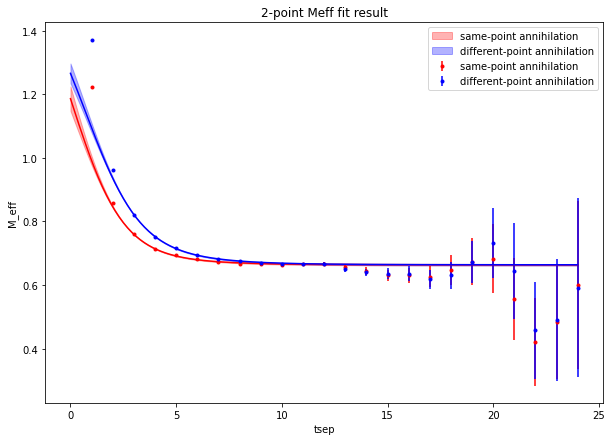

<Figure size 432x288 with 0 Axes>

In [76]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

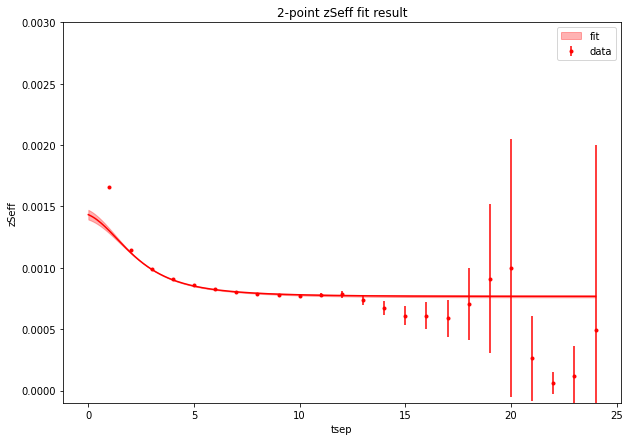

<Figure size 432x288 with 0 Axes>

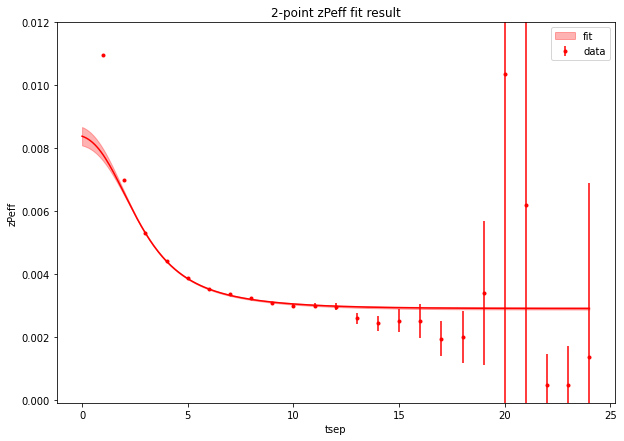

<Figure size 432x288 with 0 Axes>

In [77]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

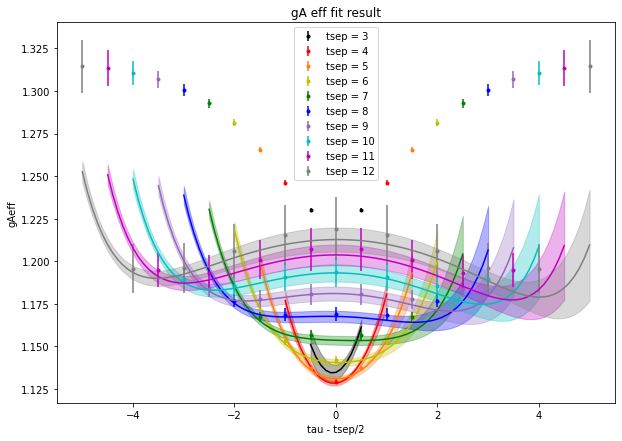

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

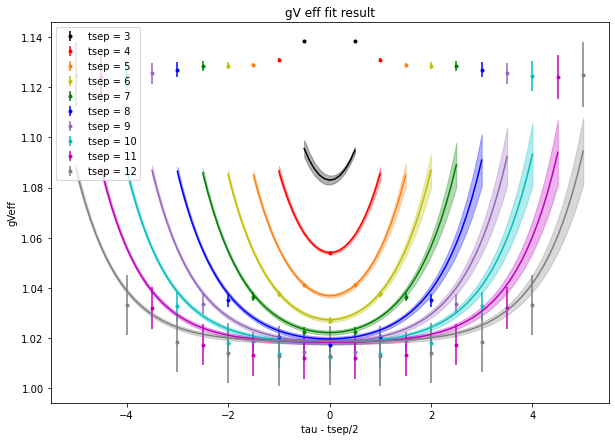

<Figure size 432x288 with 0 Axes>

In [78]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


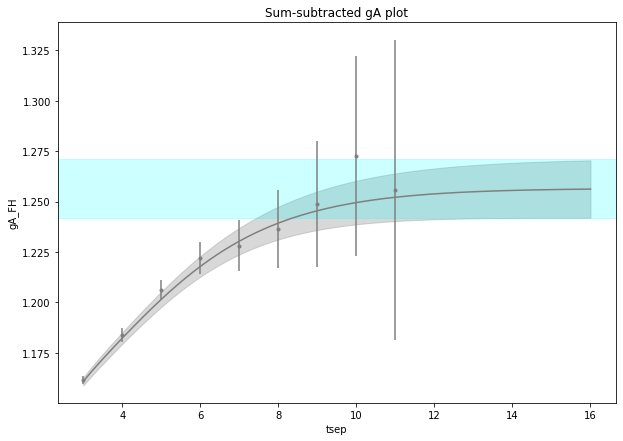

<Figure size 432x288 with 0 Axes>

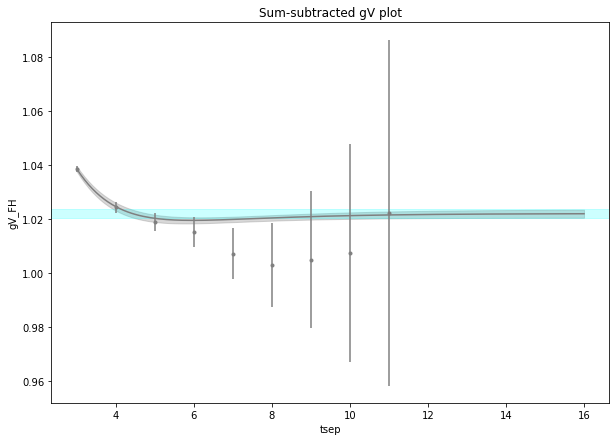

<Figure size 432x288 with 0 Axes>

In [79]:
h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_all['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_all['gV4_00'], ydat_error=y_CFH_V4_err)


In [80]:
len(post_all.keys())

69

In [81]:
for key in post_all.keys():
    print(key)

E0
Z0
Ztilde0
Z1
Ztilde1
Z2
Ztilde2
log(dE1)
log(dE2)
log(dE3)
Z3
Ztilde3
gA3_01
gV4_01
gA3_02
gV4_02
gA3_03
gV4_03
gA3_10
gV4_10
gA3_11
gV4_11
gA3_12
gV4_12
gA3_13
gV4_13
gA3_20
gV4_20
gA3_21
gV4_21
gA3_22
gV4_22
gA3_23
gV4_23
gA3_30
gV4_30
gA3_31
gV4_31
gA3_32
gV4_32
gA3_33
gV4_33
gA3_00
gV4_00
d_gA_ss_0
d_gA_ps_0
d_gV_ss_0
d_gV_ps_0
d_gA_ss_1
d_gA_ps_1
d_gV_ss_1
d_gV_ps_1
d_gA_ss_2
d_gA_ps_2
d_gV_ss_2
d_gV_ps_2
Z_FHmax
Ztilde_FHmax
log(FH_dEmax)
gA3_FHmax0
gA3_0FHmax
gV4_FHmax0
gV4_0FHmax
gA3_FHmax1
gA3_1FHmax
gV4_FHmax1
gV4_1FHmax
gA3_FHmaxFHmax
gV4_FHmaxFHmax
